In [643]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from numpy.linalg import det, inv, norm

Reference:
   
https://www.sjsu.edu/faculty/guangliang.chen/Math253S20/lec11lda.pdf

In [644]:
n_features = 30
n_informative = 10
n_redundant = 10


n_repeated=n_features-n_informative-n_redundant
if n_repeated > 0:
    print("This will make matrices singular, so normal LDA doesn't work. Need to remove collinearity before")

This will make matrices singular, so normal LDA doesn't work. Need to remove collinearity before


In [645]:
X, y = make_classification(n_samples=5000, n_features=n_features,
                           n_informative=n_informative,
                           n_redundant=n_redundant, n_repeated=n_repeated,
                           random_state=42, )

## Two necessary steps in pre-processing:
* Standard scaling - we will use a RobustScaler
* Removal of highly correlated features - simply look at the linear correlation matrix and remove highly correlated pairs

In [646]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [647]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [648]:
print("{0:.2f}".format(y_train.mean()))

0.50


#### Correlation

In [649]:
corr_thresh = 0.96

In [650]:
corrs = np.corrcoef(X_train.T)

In [651]:
features = np.arange(n_features)

For each feature, find features which are highly correlated with it and store in a dictionary.

For feature $i$, we need only look at features starting from $i+1$, since the other pairs will have been covered

In [652]:
high_corr_dict = {}
for feature in features:
    
    corr_list = corrs[feature][feature+1:]
    
    feat = features[feature+1:]

    high_corr_features = feat[corr_list>corr_thresh].tolist()
    
    high_corr_dict[feature] = high_corr_features

We now create a dictionary for features to be removed

In [653]:
remove_dict = {feat: None for feat in features}
for feat in features:
    if remove_dict[feat] is None:
        print("Analysing feature", feat)
        features_to_remove = high_corr_dict[feat]
        for featx in features_to_remove:
            remove_dict[featx] = True
            print("  > Will remove", featx)
        remove_dict[feat] = False

Analysing feature 0
  > Will remove 4
Analysing feature 1
  > Will remove 8
  > Will remove 11
Analysing feature 2
Analysing feature 3
  > Will remove 9
Analysing feature 5
  > Will remove 13
  > Will remove 16
Analysing feature 6
Analysing feature 7
Analysing feature 10
Analysing feature 12
Analysing feature 14
Analysing feature 15
  > Will remove 20
Analysing feature 17
  > Will remove 23
Analysing feature 18
Analysing feature 19
  > Will remove 21
Analysing feature 22
Analysing feature 24
Analysing feature 25
  > Will remove 29
Analysing feature 26
Analysing feature 27
Analysing feature 28


In [654]:
feats_to_keep = [key for key, value in remove_dict.items() if not value]

In [655]:
feats_to_keep

[0, 1, 2, 3, 5, 6, 7, 10, 12, 14, 15, 17, 18, 19, 22, 24, 25, 26, 27, 28]

In [656]:
X_train = X_train[:, feats_to_keep]
X_test = X_test[:, feats_to_keep]

In [657]:
n_features = len(feats_to_keep)

In [658]:
print(n_features)

20


#### Outlier removal

In [659]:
scaler = RobustScaler(quantile_range=(5,95))
X_train = scaler.fit_transform(X_train)

We have kept 3500 out of 3500 rows, or 100% of rows


In [626]:
X_test = scaler.transform(X_test)

## Start LDA

Step 1: calculate group-wise means

In [627]:
x1 = X_train[y_train==1]
x0 = X_train[y_train==0]

y1 = y_train[y_train==1]
y0 = y_train[y_train==0]

In [628]:
mu1 = x1.mean(axis=0)
mu0 = x0.mean(axis=0)

In [629]:
def cov_matrix(x, mean, n_features):
    soma = np.zeros((n_features,n_features))
    for u in (x - mean):
        v = u.reshape(n_features,1)
        soma += np.matmul(v, v.T)
    return soma

In [630]:
S1 = cov_matrix(x1, mu1, n_features=n_features)
S0 = cov_matrix(x0, mu1, n_features=n_features)

In [631]:
Sw = S1 + S0
Sw = Sw/np.max(Sw) # normalizing changes nothing but helps inversion

In [632]:
Sw.round(2)

array([[ 0.86,  0.17, -0.27, -0.04,  0.01,  0.03,  0.02, -0.48,  0.17,
         0.06, -0.36, -0.43, -0.3 , -0.23,  0.17,  0.39, -0.14,  0.12,
         0.23, -0.03],
       [ 0.17,  0.86, -0.13, -0.12, -0.03,  0.13,  0.04,  0.04, -0.19,
         0.41, -0.01, -0.24,  0.01,  0.38,  0.16,  0.16, -0.04,  0.4 ,
         0.37, -0.57],
       [-0.27, -0.13,  0.81, -0.02,  0.48, -0.05, -0.16,  0.13, -0.47,
         0.22, -0.1 , -0.02, -0.  ,  0.25,  0.09,  0.01, -0.15, -0.08,
        -0.27,  0.1 ],
       [-0.04, -0.12, -0.02,  0.87,  0.11, -0.15, -0.08,  0.15,  0.23,
        -0.39, -0.1 ,  0.11, -0.04,  0.11, -0.15, -0.49, -0.11, -0.34,
        -0.07,  0.48],
       [ 0.01, -0.03,  0.48,  0.11,  0.82, -0.05, -0.3 ,  0.19, -0.19,
         0.29, -0.23, -0.34,  0.36,  0.31, -0.09,  0.14, -0.08,  0.1 ,
        -0.05, -0.06],
       [ 0.03,  0.13, -0.05, -0.15, -0.05,  0.78, -0.42, -0.38,  0.2 ,
        -0.29,  0.13,  0.16, -0.25,  0.38, -0.35,  0.17, -0.37, -0.08,
        -0.58,  0.06],
       [ 0

In [633]:
w = np.matmul(inv(Sw), (mu1-mu0).reshape(n_features,1))

In [634]:
w = w/norm(w)

In [635]:
def projector(w):
    def f(x):
        return np.dot(x, w)
    return f

In [636]:
proj = projector(w)

In [637]:
x_proj = np.concatenate([proj(x1), proj(x0)])
y_proj = np.concatenate([y1, y0])

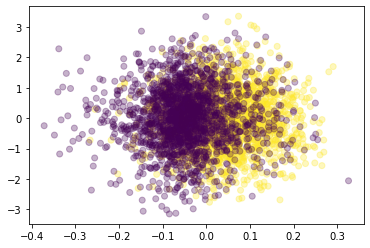

In [638]:
plt.scatter(x_proj, np.random.randn(len(x_proj)), c=y_proj, alpha=0.3)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


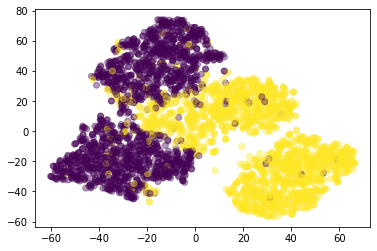

In [639]:
if n_features == 3:
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2], c=y_train)

elif n_features > 3:
    sne = TSNE(init='pca')
    x_sne = sne.fit_transform(X_train, y_train, )
    plt.scatter(x_sne[:,0], x_sne[:,1], c=y_train, alpha=0.4)
plt.show()

# Make into class

In [679]:
class BinaryFisherDiscriminantAnalysis:
    
    def __init__(self, 
                 scaler='robust',
                 correlation_threshold=0.98,
                 robust_scaler_quantiles=(5,95)):
        
        assert scaler in ['robust', 'standard']
        assert (0 < correlation_threshold <= 1)
        if scaler == 'robust':
            self.scaler = RobustScaler(quantile_range=robust_scaler_quantiles)
        else:
            self.scaler = StandardScaler()
            
        self.correl_thresh = correlation_threshold

        self.n_features = None
        self.feats_to_keep = None
        
    def fit(self, X, y):
        
        self._remove_collinearity(X)  # --> this creates a. self.feats_to_keep list and self.n_features
        self._scale_variables(X)
        self._fit_lda(X, y)
        
    def _remove_collinearity(self, X):
        
        n_features = X.shape[1]
        
        # correlation matrix
        corrs = np.corrcoef(X.T)

        # encode features as integers in [0, n_features-1]
        features = np.arange(n_features)

        # for each feature, find features which are highly correlated with it and store in a dictionary.
        # for feature $i$, we need only look at features starting from $i+1$, since the 
        # other pairs will have been covered

        high_corr_dict = {}
        for feature in features:

            corr_list = corrs[feature][feature+1:]
            feat = features[feature+1:]
            high_corr_features = feat[corr_list>self.correl_thresh].tolist()

            high_corr_dict[feature] = high_corr_features

        # We now create a dictionary for features to be removed
        remove_dict = {feat: None for feat in features}
        for feat in features:
            if remove_dict[feat] is None:
                print("Analysing feature", feat)
                features_to_remove = high_corr_dict[feat]
                for featx in features_to_remove:
                    remove_dict[featx] = True
                    print("  > Will remove", featx)
                remove_dict[feat] = False

        self.feats_to_keep = [key for key, value in remove_dict.items() if not value]
        self.n_features = n_features
        
    def _scale_variables(self, X):
        self.scaler.fit(X)
    
    def _fit_lda(self, X, y):
        
        X_train = self.scaler.transform(X)
        
        




In [680]:
BinaryFisherDiscriminantAnalysis()

In [670]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

In [664]:
roc_auc_score(y_proj, x_proj)

0.7808447225332598

In [671]:
average_precision_score(y_proj, x_proj)

0.7525396823504029

In [672]:
prec, rec, _ = precision_recall_curve(y_proj, x_proj)

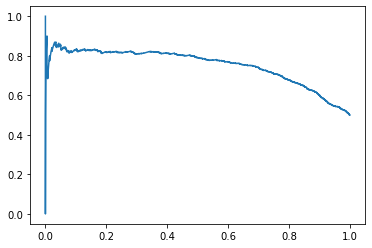

In [673]:
plt.plot(rec, prec)
plt.show()

In [666]:
fpr, tpr, _ = roc_curve(y_proj, x_proj)

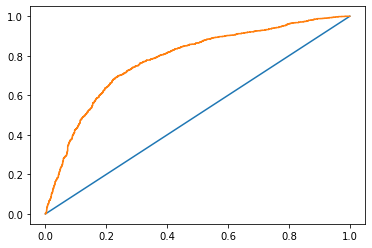

In [669]:
plt.plot([0,1])
plt.plot(fpr, tpr)